# Gaussian processes
A notebook to practice and learn more about Gaussian processes.

This notebook follows (parts of) the book "Gaussian Processes for Machine Learning" http://www.gaussianprocess.org/gpml/

## Problem setup
We want to model a unkown function $f(\textbf{x}) = y$

And we have a set $\mathcal{D}$ with $n$ samples, a.k.a. *trainging data*

$$
\mathcal{D} = \{(\textbf{x}_i,y_i) | i=1,...,n \}
$$

We save these is the matrix $X$ and vector $Y$

$$
    X = [\textbf{x}_1,...,\textbf{x}_n],\quad Y = [y_1,...,y_n]^\top
$$

For these examples, $\textbf{x}$ will be 1-dimension.

## Standard Linear Model
In this case, the unkown function can be described as

$$
f(\textbf{x}) = \textbf{x}^\top w + b = y
$$

where $w$ is the linear weights, and $b$ is a bias/constant offset.

Using the defined $X,Y$, it becomes

$$
    Y = X^\top w + b
$$



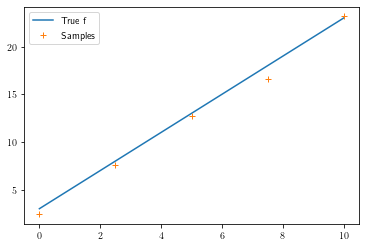

In [22]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rc

# Enable LaTeX rendering in matplotlib
rc('text', usetex=True)


# Seed random nr
np.random.seed(1337)

# Choose true function that is supposed to be estimated

w_true = 2
bias_true = 3

def linear_model(x,w):
    return np.dot(x,w)

def f_true(x):
    return linear_model(x,w_true) + bias_true


# Generate samples/trainging data

sigma_n = 0.8 # Meas noise standard deviation
n = 5 # Nr of samples

X = np.linspace(0,10,n)
y = f_true(X) + sigma_n*np.random.randn(n)

plt.plot(X,f_true(X))
plt.plot(X,y,'+')
plt.legend(['True f','Samples'])
plt.show()


Given a *prior* for the weights $w \sim \mathcal{N}(0,\Sigma_p)$.

The estimate of $w$ is then given as

$$
\hat w =\frac{1}{\sigma_n^2} A^{-1}XY
$$

$$
A = \sigma_n^{-2}XX^\top + \Sigma_p^{-1}
$$

Or in a more Bayesian way of writing, the distribution of $w$, given $X,Y$ is
$$
p(w|X,Y)  \sim \mathcal{N}(\frac{1}{\sigma_n^2} A^{-1}XY, A^{-1}) 
$$

In [23]:
from numpy.linalg import inv
from scipy.linalg import sqrtm

sigma_p = np.eye(2)*10 # Priori, w std deviation

M = np.vstack((X,np.ones((n,)))) # Adding ones to estimate bias, so from here on, M is used instead of X

A = 1/(sigma_n**2)*M@M.T + inv(sigma_p)

w_hat = (sigma_n**-2)*inv(A)@M@y

w_sigma = np.sqrt(A[0,0])
b_sigma = np.sqrt(A[1,1])



print(f"True w:{w_true} and b:{bias_true}")
print(f"Estimated w:{w_hat[0]}")
print(f"Estimated b:{w_hat[0]}")
print("Covariance matrix")
print(sqrtm(A))

True w:2 and b:3
Estimated w:2.027669133969387
Estimated b:2.027669133969387
Covariance matrix
[[16.9940637  2.0665307]
 [ 2.0665307  1.9083896]]


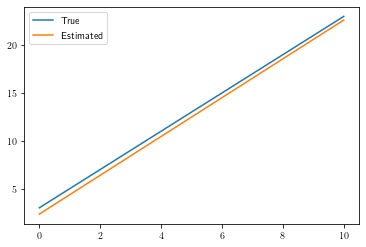

In [24]:
def f_estimated(x):
    return x*w_hat[0] + w_hat[1] 

    
plt.plot(X,f_true(X))
plt.plot(X,f_estimated(X))
plt.legend(['True','Estimated'])
plt.show()   

### Make predictions of new inputs (With uncertainties)
Previously we used the estimated weights to plot the function, but we can instead take a more bayesian approach by using the known samples to make predictions of new input samples, and also deliver variances/uncertainties for the predictions.

Given a new input $\textbf{x}_*$ the predicted output $y_*$ is then given as

$$
    p(y_*|x_*,X,Y) = \mathcal{N}(\sigma_n^{-2}\textbf{x}_*^\top A^{-1}XY, \textbf{x}_*^\top A^{-1}\textbf{x}_*)
$$


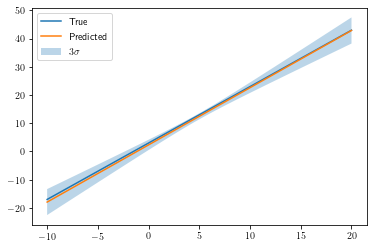

In [27]:

def f_predict(x):
    xn = len(x)
    x = np.vstack((x,np.ones(xn,)))
    return sigma_n**(-2)*x.T@inv(A)@M@y

# Return variance of prediction at x
def f_predict_uncertainty(x):
    xn = len(x)
    y = np.zeros((xn,))
    A_inv = inv(A)
    for i in range(xn):
        xi = np.array([x[i],1])
        y[i] = xi.T @ A_inv @ xi
    return y

XT = np.linspace(-10,20,30)

plt.plot(XT,f_true(XT))
y_pred = f_predict(XT)
plt.plot(XT,y_pred)
y_sigma = 3*np.sqrt(f_predict_uncertainty(XT))
plt.fill_between(XT,y_pred - y_sigma,y_pred+y_sigma,alpha=0.3)
plt.legend(['True','Predicted','$3\sigma$'])
plt.show()


As can bee seen, after plotting the 3$\sigma$ uncertainty bounds, the true function always lies within the uncertainty bounds.

The biggest question I've been thinking about when writing this example is how would one go about doing this if $\sigma_n$ is unkown? 

One possible way would be to first try and do a least square fit of the parameter, thus is only the model structure is assumed. After estimating the parameters using the least square method, the variance of the error $y-\hat y$ can be estimated and assumed to be $\sigma_n$. But I do not know if this is the "proper way" to do this.

## Projection of inputs into Feature Space

This is a simple extension to the linear weighted model. Where some inputs are feed through a function before beeing weighted.
For instance a polynominal 

$$
y = f(x) =  a_2 x^2 + a_1 x + a_0
$$ 

if the input $x$ is known, then $x^2$ can be computed before trying to winding the linear parameters $a_2,a_1,a_0$ just as before.

We introduce the mapping 
$$
\Phi(x) = [1 \quad x \quad x^2]^\top
$$

And defining $a = [a_0\quad a_1 \quad a_2]$, we can write the function as

$$
    y = f(x) = \Phi(x)^\top a
$$

Wich is basicaly the same expression as in the previous section

$$
    f(x) = \Phi(x)^\top w + \epsilon
$$


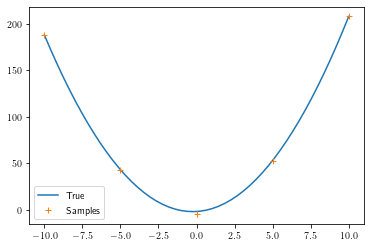

In [33]:
# Samples from true function

a_true = np.array([-2,1,2])

def f_true(x):
    return (x**2)*a_true[2] + x*a_true[1] + a_true[0]

n = 5
sigma_n = 1

X = np.linspace(-10,10,n)
y = f_true(X) + sigma_n*np.random.randn(n)

XT = np.linspace(-10,10)

plt.plot(XT,f_true(XT))
plt.plot(X,y,'+')
plt.legend(['True','Samples'])
plt.show()



$\texttt{TODO...}$

## First Steps of making predictions

The foundational idea behind the function estimation, is to make predictions given a few samples.

The only thing we specify exept from the samples, is the covariance function, the common choice in the book is *the squared exponential*

$$
k(x,x') = \texttt{exp}(\frac{-1}{2}|x - x'|^2)
$$

## Predictions using noise free samples/observations

The most important equation according to me, is the following, that represents the joint gaussian distribrution between, samples/training data $X,Y$ and predicitions ($Y_*$) of new input data $X_*$

$$
    \left[
    \begin{array}{c}
    Y\\
    Y_*
    \end{array}
    \right]
    \sim \mathcal{N}
    \left(
    \left[
    \begin{array}{c}
    0\\
    0
    \end{array}
    \right]
    ,
    \begin{array}{c c}
    K(X,X) & K(X,X_*) \\
    K(X_*,X) & K(X_*,X_*)
    \end{array}
    \right)
$$

## Breaking down the Joint distribrution
At first the equation for the joint distribrution may seem scary, but after defining what $K(.,.)$ is, and revisiting some known properties for a joint gaussian distribrution, it will seem much less scary.

$$K(X,X') = 
\left[
\begin{array}{ccc}
k(x_1,x_1') & ... & k(x_1,x_n') \\
\vdots & \ddots & \vdots \\
k(x_n,x_1') & ... & k(x_n,x_n')
\end{array}
\right]
$$

Given two random variables $x,y$ and their joint gaussian distribrution

$$
    \left[
    \begin{array}{c}
    x\\
    y
    \end{array}
    \right]
    \sim 
    \mathcal{N}
    \left(
    \left[
    \begin{array}{c}
    \mu_x\\
    \mu_y
    \end{array}
    \right]
    ,
    \left[
    \begin{array}{c c}
    A & B \\
    C & D
    \end{array}
    \right]
    \right)
$$

Then the following is true

$$
    p(x) =\mathcal{N}\left(\mu_x,A\right)
$$

$$
    p(x|y) = \mathcal{N}\left(\mu_x + CB^{-1}(y - \mu_y),A - CB^{-1}C^\top\right)
$$

Where the last statement is importance for our usage. Using that four our data yields the equation for predictions


$$
\begin{split}
p(Y_*|X_*,X,Y) = \mathcal{N}\left(
K(X_*,X)K(X,X)^{-1}Y, \\
K(X_*,X_*) - K(X_*,X)K(X,X)^{-1}K(X,X_*)\right)
\end{split}
$$

Or put more easily, the predicitons are given as

$$
\begin{split}
Y_* &= K(X_*,X)K(X,X)^{-1}Y \\
\texttt{cov}(Y_*) &= K(X_*,X_*) - K(X_*,X)K(X,X)^{-1}K(X,X_*)
\end{split}
$$

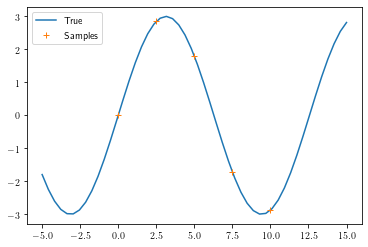

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd

# Samples and true function

rnd.seed(42)

n = 5

X = np.linspace(0,10,n)

def f_true(x):
    return 3*np.sin(x*0.5)

Y = f_true(X)

XT = np.linspace(-5,15)

plt.plot(XT,f_true(XT))
plt.plot(X,Y,'+')
plt.legend(['True','Samples'])
plt.show()


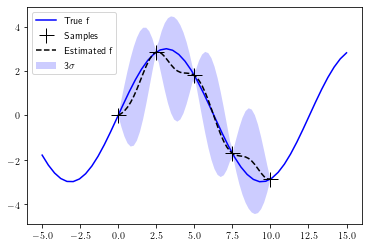

In [31]:
from numpy.linalg import inv
from matplotlib import rc
# Enable LaTeX rendering in matplotlib
rc('text', usetex=True)


# Predictions

def pred_example(tune_param):
    # Covariance function
    def cov_f(x1,x2):
        return np.exp(-1/2*np.abs(x1-x2)**2*tune_param)

    # Creates K(X,X') matrices
    def K(X1,X2):
        n1 = len(X1)
        n2 = len(X2)
        K = np.zeros((n1,n2))

        for i in range(n1):
            for j in range(n2):
                K[i,j] = cov_f(X1[i],X2[j])


        return K

    # New inputs
    XS = np.linspace(0,10)

    YS = K(XS,X)@inv(K(X,X))@Y

    YS_COV = K(XS,XS) - K(XS,X)@inv(K(X,X))@K(X,XS)

    YS_sigma = np.sqrt(np.diagonal(YS_COV))

    plt.plot(XT,f_true(XT),'b')
    plt.plot(X,Y,'k+',markersize=15)
    plt.plot(XS,YS,'k--')
    #plt.plot(XS,YS + YS_sigma*3,'--')
    plt.fill_between(XS,YS - YS_sigma*3,YS + YS_sigma*3,facecolor='b',alpha=0.2)
    plt.legend(['True f','Samples','Estimated f','3$\sigma$'])
    plt.show()


pred_example(1)
    

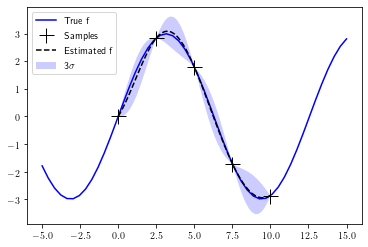

In [32]:
# But tuning the covariance function, yields better covariance/uncertainty/3 sigma curves
pred_example(1/4)

## Making predictions using noisy samples/observations

Previously the samples/observations were assumed to be noise free, but it is possible to make predictions using nosiy samples.

Denoting the measurement noise as $\sigma_n$, the equations for prediction now become


$$
\begin{split}
Y_* &= K(X_*,X)\left(K(X,X) + \sigma_n^2 I)\right)^{-1}Y \\
\texttt{cov}(Y_*) &= K(X_*,X_*) - K(X_*,X)\left(K(X,X) + \sigma_n^2 I)\right)^{-1}K(X,X_*)
\end{split}
$$


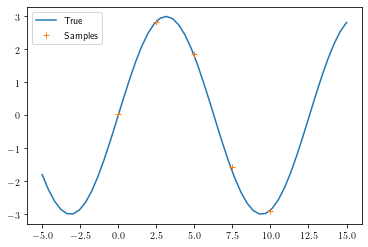

In [50]:
# Modyfing the same example again, but with meas noise

sigma_n = 0.1

rnd.seed(42)

n = 5

X = np.linspace(0,10,n)

def f_true(x):
    return 3*np.sin(x*0.5)

Y = f_true(X) + sigma_n*rnd.randn(len(X))

XT = np.linspace(-5,15)

plt.plot(XT,f_true(XT))
plt.plot(X,Y,'+')
plt.legend(['True','Samples'])
plt.show()


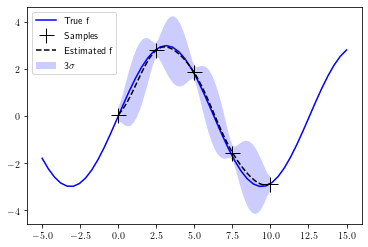

In [52]:
def pred_example_w_noise(tune_param):
    # Covariance function
    def cov_f(x1,x2):
        return np.exp(-1/2*np.abs(x1-x2)**2*tune_param)

    # Creates K(X,X') matrices
    def K(X1,X2):
        n1 = len(X1)
        n2 = len(X2)
        K = np.zeros((n1,n2))

        for i in range(n1):
            for j in range(n2):
                K[i,j] = cov_f(X1[i],X2[j])


        return K

    # New inputs
    XS = np.linspace(0,10)
    I = np.eye(len(X))
    YS = K(XS,X)@inv(K(X,X) + sigma_n**2*I)@Y

    YS_COV = K(XS,XS) - K(XS,X)@inv(K(X,X) + sigma_n**2*I)@K(X,XS)

    YS_sigma = np.sqrt(np.diagonal(YS_COV))

    plt.plot(XT,f_true(XT),'b')
    plt.plot(X,Y,'k+',markersize=15)
    plt.plot(XS,YS,'k--')
    #plt.plot(XS,YS + YS_sigma*3,'--')
    plt.fill_between(XS,YS - YS_sigma*3,YS + YS_sigma*3,facecolor='b',alpha=0.2)
    plt.legend(['True f','Samples','Estimated f','3$\sigma$'])
    plt.show()
pred_example_w_noise(0.5)

## Tuning of Covariance function

Or as the machine learning neerds call it *hyper parameter optimization*
